In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import ndimage

In [2]:
# 1

# load the image and convert to grayscale
image_file_path = 'isaac.jpg'
image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
image = image.astype(np.float32)

# parameter for Gaussian noise
std_dev = 20                # known standard deviation for Gaussian noise
mean = 0                    # Mean of the Gaussian noise
num_noisy_images = 10       # Number of noisy images to generate

# generate 10 noisy versions of grayscale image

noisy_images = []
for i in range(num_noisy_images):
    noise = np.random.normal(mean, std_dev, image.shape).astype(np.float32)
    noisy_image = np.clip(image + noise, 0, 255) 
    noisy_images.append(noisy_image)

# compute the noise power as the mean of the noise variance
noise_power = np.mean(np.var([noisy_image for noisy_image in noisy_images], axis=0))

# computer the signal power as the variance of the original image
signal_power = np.var(image)

# compute the SNR in decibels (dB)
snr = 10 * np.log10(signal_power / noise_power)

print('SNR: ', snr, ' dB')



SNR:  9.773658514022827  dB


Manual convolution time: 0.18005 seconds
OpenCV convolution time (zero padding): 0.00014 seconds


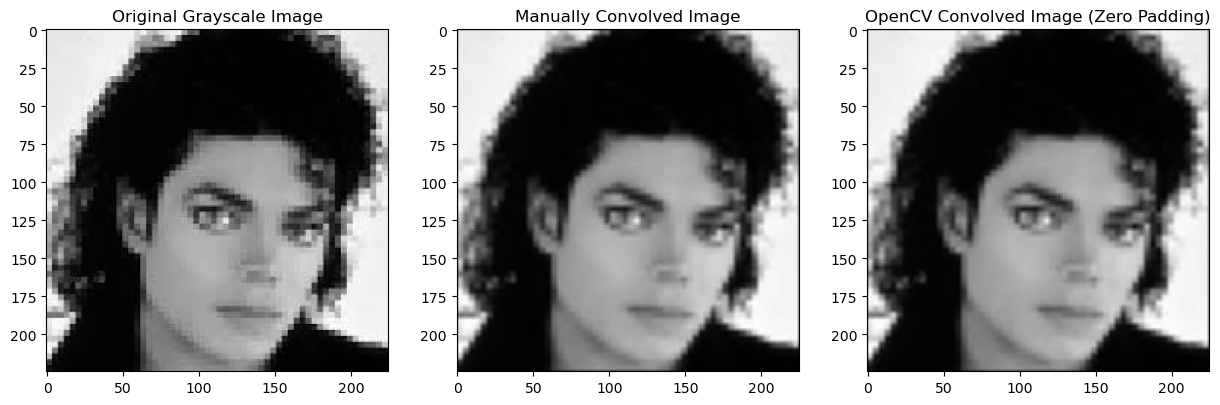

The differences in run time is possibly contributed to the fact that openCV is implemented and compiled in C or C++, which is a much lower level and optimized language compared to Python. Even a simple for loop in python can be many times slower than ones implemented in C. There are also other optimizations that could have been done to make OpenCV's implementation faster, such as multithreading and memory optimization.


In [3]:
# 2

# function for manual conv using zero padding
def manual_convolution(image, kernel):
    # assuming 3x3 for kernel shape

    # dim of img
    img_height, img_width = image.shape

    # pad the image with 0s
    padded_img = np.pad(image, 1, mode='constant', constant_values=0)

    output_image = np.zeros((img_height, img_width))

    # range from pad size to image height + pad size
    for i in range(1, img_height + 1):
        for j in range(1, img_width + 1):
            # 3x3 area conv is being applied to
            region = padded_img[i - 1:i + 2, j - 1: j + 2]

            conv_val = np.sum(region * kernel)

            # assign the result to the output image
            output_image[i - 1, j - 1] = conv_val
        
    output_image = np.clip(output_image, 0, 255)

    return output_image


    

# load the image and convert it to grayscale
image = cv2.imread('mj.jpg', cv2.IMREAD_GRAYSCALE)

# define a 3x3 averaging filter (kernel)
kernel = np.ones((3, 3)) / 9.0

# time the convolution implementation
start_manual = time.time()
smooth_image_manual = manual_convolution(image, kernel)
end_manual = time.time()
start_opencv = time.time()
smoothed_image_opencv = cv2.filter2D(image, -1, kernel, borderType=cv2.BORDER_CONSTANT)
end_opencv = time.time()
print(f"Manual convolution time: {end_manual - start_manual:.5f} seconds")
print(f"OpenCV convolution time (zero padding): {end_opencv - start_opencv:.5f} seconds")

# display the original, manually convolved, and OpenCV-convoled images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Grayscale Image")
plt.subplot(1, 3, 2)
plt.imshow(smooth_image_manual, cmap='gray')
plt.title("Manually Convolved Image")
plt.subplot(1, 3, 3)
plt.imshow(smoothed_image_opencv, cmap='gray')
plt.title("OpenCV Convolved Image (Zero Padding)")
plt.show()

print("The differences in run time is possibly contributed to the fact that openCV is implemented and compiled in C or C++, which is a much lower level and optimized language compared to Python. Even a simple for loop in python can be many times slower than ones implemented in C. There are also other optimizations that could have been done to make OpenCV's implementation faster, such as multithreading and memory optimization.")

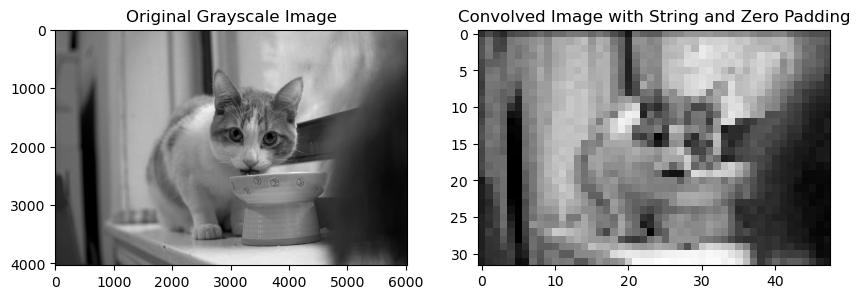

In [4]:
# 3

# function for conv with stride and zero padding, accepting kernel as argument
def convolution_with_stride(image, kernel, stride=1):
    # assume 3x3 kernel shape

    # dim of img 
    img_height, img_width = image.shape

    # pad the image with 0s
    padded_img = np.pad(image, 1, mode='constant', constant_values=0)

    # (((W - K + 2P)/S) + 1)
    out_height = (img_height - 3 + (2 * 1)) // stride + 1
    out_width = (img_width - 3 + (2 * 1)) // stride + 1
    output_image = np.zeros((out_height, out_width))

    # range from 0 to expected output size
    for i in range(0, out_height):
        for j in range(0, out_width):
            start_i = i * stride
            start_j = j * stride

            # 3x3 area conv is being applied to
            region = padded_img[start_i :start_i + 3, start_j : start_j + 3]

            conv_val = np.sum(region * kernel)

            # assign the result to the output image
            output_image[i, j] = conv_val
        
    output_image = np.clip(output_image, 0, 255)

    return output_image

# load the image and convert it to grayscale
image = cv2.imread('isaac.jpg', cv2.IMREAD_GRAYSCALE)

# Define a 3x3 averaging filter (kernel) as an argument
kernel = np.ones((3, 3)) / 9.0

# apply the conv
smoothed_image_stride = convolution_with_stride(image, kernel, stride=128)

# display the original and convolved images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Grayscale Image")
plt.subplot(1, 2, 2)
plt.imshow(smoothed_image_stride, cmap='gray')
plt.title("Convolved Image with String and Zero Padding")
plt.show()

Gaussian Kernel (5x5):
 [[0.00069697 0.00614954 0.01270724 0.00614954 0.00069697]
 [0.00614954 0.05425859 0.11211848 0.05425859 0.00614954]
 [0.01270724 0.11211848 0.23167856 0.11211848 0.01270724]
 [0.00614954 0.05425859 0.11211848 0.05425859 0.00614954]
 [0.00069697 0.00614954 0.01270724 0.00614954 0.00069697]]


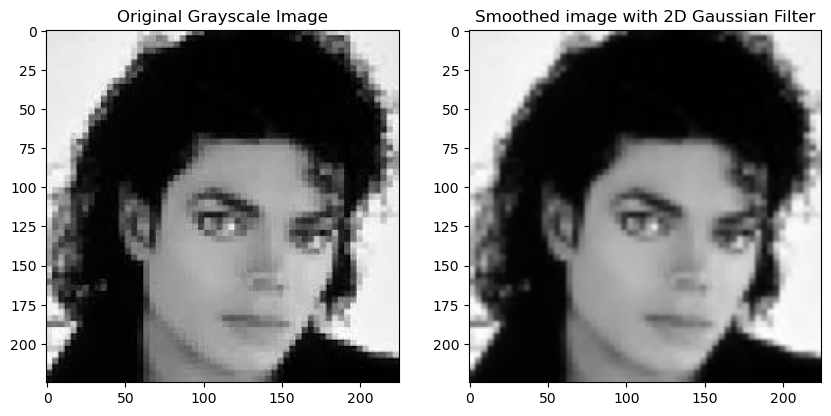

As sigma increases, the values in the kernel becomes more spread out (further from center pixels influence increases). If sigma is too big, will act as a mean filter instead.
+- 3 sigma covers 99.7% of a gaussian curve. Therefore if you want to fit 99.7% or the majority of a nxn kernel, you would need sigma to be n/6 or 5/6 or 0.83 in this case


In [5]:
# 4

# function to generate a 2D Gaussian kernel
# G_sigma(x, y) = e^(-(x^2 + y^2)/(2 sigma^2)) (un-normalized)
def gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2 # cetner of kernel

    for i in range(size):
        for j in range(size):
            x_dist = (i - center) ** 2
            y_dist = (j - center) ** 2

            # apply the gaussian formula
            kernel[i, j] = np.exp(-(x_dist + y_dist) / (2 * (sigma ** 2)))

    kernel /= np.sum(kernel) # normalize the kernel otherwise brightness might be off
    return kernel

# load the image and convert to grayscale
image = cv2.imread('mj.jpg', cv2.IMREAD_GRAYSCALE)

# generate and display the 2D gaussian kernel
kernel_size = 5 # 5x5 kernel
sigma = 0.83 # standard deviation for the gaussian
gaussian_kernel_2d = gaussian_kernel(kernel_size, sigma=sigma)
print("Gaussian Kernel (5x5):\n", gaussian_kernel_2d)

# apply the gaussian filter to the image using OpenCV's filter2D
smoothed_image = cv2.filter2D(image, -1, gaussian_kernel_2d)

# display the original and smoothed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Grayscale Image")
plt.subplot(1, 2, 2)
plt.imshow(smoothed_image, cmap='gray')
plt.title('Smoothed image with 2D Gaussian Filter')
plt.show()

print("As sigma increases, the values in the kernel becomes more spread out (further from center pixels influence increases). If sigma is too big, will act as a mean filter instead.")
print(f"+- 3 sigma covers 99.7% of a gaussian curve. Therefore if you want to fit 99.7% or the majority of a nxn kernel, you would need sigma to be n/6 or 5/6 or 0.83 in this case")

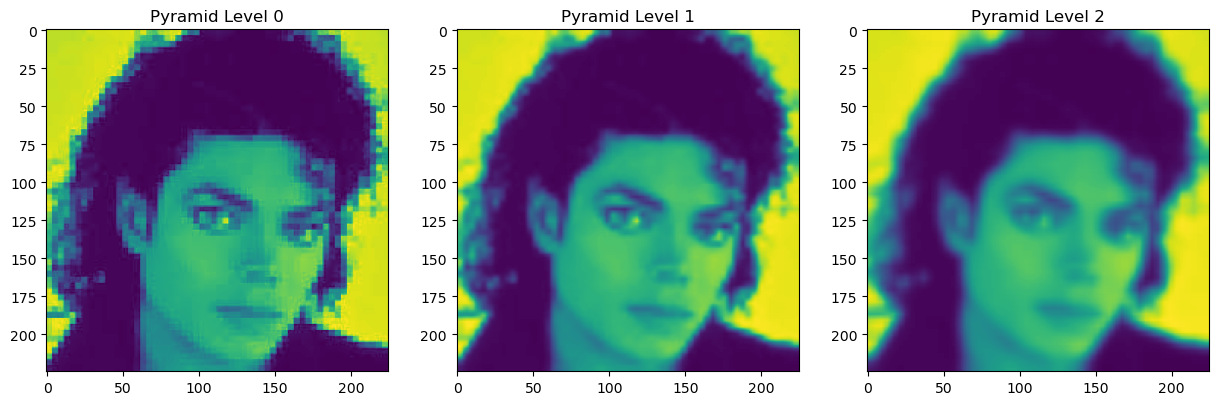

In [6]:
# 5

image = cv2.imread('mj.jpg', cv2.IMREAD_GRAYSCALE)

# compute gaussian pyramid
def gaussian_pyramid(image, levels=3):
    pyramid = [image]
    for i in range(1, levels):
        pyramid.append(cv2.pyrDown(pyramid[-1]))
    return pyramid

# display pyramid with resized layers
pyramid_layers = gaussian_pyramid(image)
resized_pyramid_layers = [cv2.resize(layer, (image.shape[1], image.shape[0])) for layer in pyramid_layers]

# display results
plt.figure(figsize=(15, 5))
for i, layer in enumerate(resized_pyramid_layers):
    plt.subplot(1, len(resized_pyramid_layers), i+1)
    plt.imshow(layer)
    plt.title(f"Pyramid Level {i}")

plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


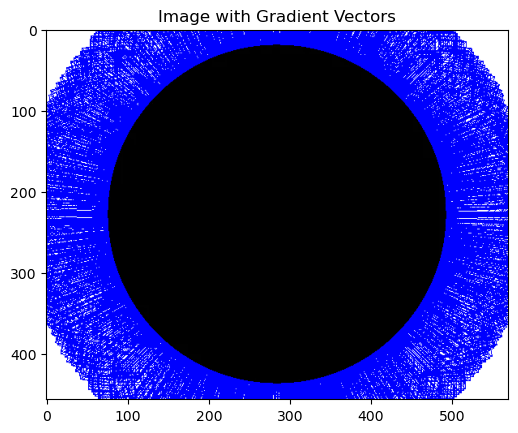

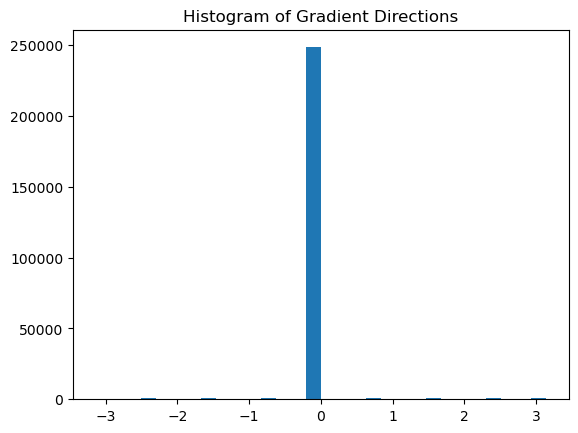

In [7]:
# 6

# load the image
image = cv2.imread('circle.jpg', cv2.IMREAD_GRAYSCALE)

# compute the gradients
grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0)
grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1)
print(grad_x, grad_y)
magnitude = np.sqrt(grad_x**2 + grad_y**2)
direction = np.arctan2(grad_y, grad_x)

# draw the gradient vectors
image_with_vectors = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
threshold = 100
strong_magnitudes = magnitude > threshold 
y_coords, x_coords = np.where(strong_magnitudes)

# draw gradient vectors (arrows) on the image
for y, x in zip(y_coords, x_coords):
    dx = int(grad_x[y, x] / 10)
    dy = int(grad_y[y, x] / 10)
    start_point = (x, y)
    end_point = (x + dx, y + dy)
    cv2.arrowedLine(image_with_vectors, start_point, end_point, (0, 0, 255), 1, tipLength=0.3)

# display the results
plt.imshow(image_with_vectors)
plt.title("Image with Gradient Vectors")
plt.show()
plt.hist(direction.ravel(), bins=30)
plt.title("Histogram of Gradient Directions")
plt.show()  

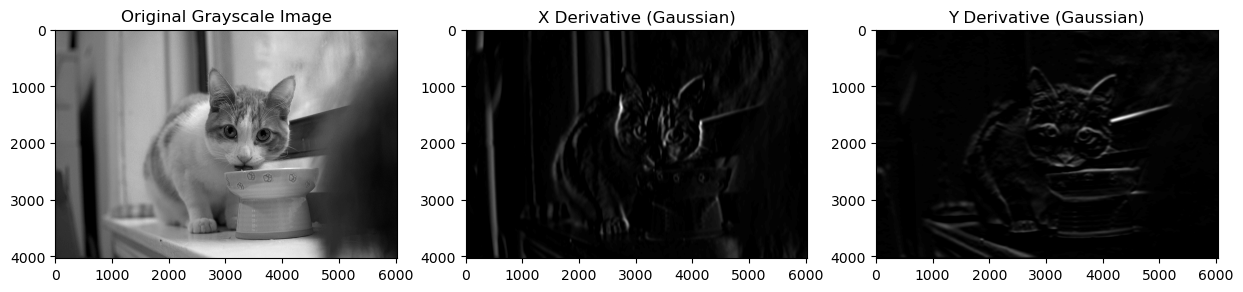

In [8]:
# 7

# function to generate a 1D gaussian kernel
def gaussian_1d(size, sigma):
    # G_sigma(x) = e^(-(x^2)/(2 sigma^2)) (un-normalized)
    kernel = np.zeros(size)
    center = size // 2
    for i in range(size):
        dist = (i - center) ** 2
        kernel[i] = np.exp(-(dist)/(2 * sigma ** 2))
    return kernel / np.sum(kernel) # normalize

# function to generate a 1d gaussian derivative kernel
def gaussian_derivative_1d(size, sigma):
    kernel = np.zeros(size)
    center = size // 2
    for i in range(size):
        dist = (i - center)
        kernel[i] = (-dist/(sigma**2)) * np.exp(-(dist ** 2)/(2 * sigma ** 2))
    return kernel / np.sum(np.abs(kernel))

# define parameters for gaussian fitlers
kernel_size = 100
sigma = 20.0

# compute 1D filter
gaussian_x = gaussian_1d(kernel_size, sigma=sigma).reshape(1, -1)
gaussian_y = gaussian_1d(kernel_size, sigma=sigma).reshape(-1, 1)
gaussian_derivative_x = gaussian_derivative_1d(kernel_size, sigma).reshape(1, -1)
gaussian_derivative_y = gaussian_derivative_1d(kernel_size, sigma).reshape(-1, 1)

# load the image and convert it to grayscale
image = cv2.imread('isaac.jpg', cv2.IMREAD_GRAYSCALE)

# detect X derivative
image_x_derivative = cv2.filter2D(image, -1, gaussian_derivative_x)
image_x_derivative = cv2.filter2D(image_x_derivative, -1, gaussian_y)

# detect Y derivative
image_y_derivative = cv2.filter2D(image, -1, gaussian_derivative_y)
image_y_derivative = cv2.filter2D(image_y_derivative, -1, gaussian_x)

# display the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Grayscale Image")
plt.subplot(1, 3, 2)
plt.imshow(image_x_derivative, cmap='gray')
plt.title("X Derivative (Gaussian)")
plt.subplot(1, 3, 3)
plt.imshow(image_y_derivative, cmap='gray')
plt.title("Y Derivative (Gaussian)")
plt.show()



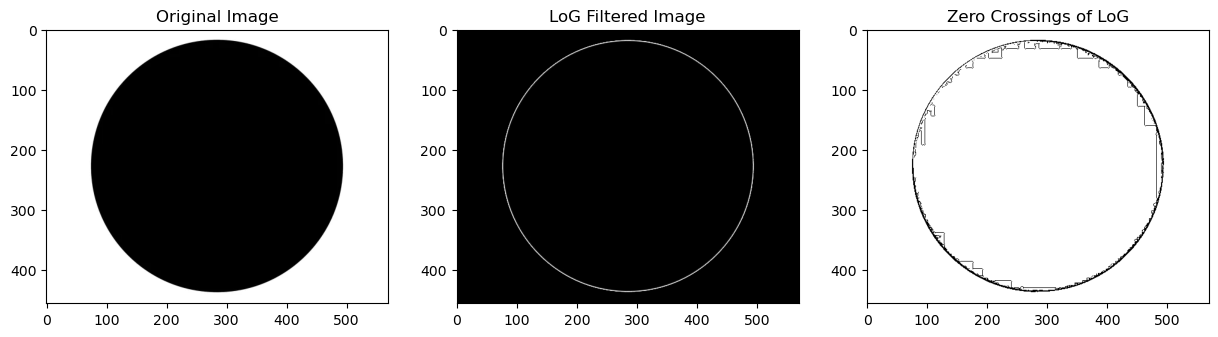

In [9]:
# 8

# function to create a laplacian of gaussian filter
def laplacian_of_gaussian(size, sigma):
    kernel = np.zeros((size, size))
    center = size // 2

    for i in range(size):
        for j in range(size):
            x_dist = (i - center) ** 2
            y_dist = (j - center) ** 2

            # apply the gaussian formula
            

            # laplacian formula:
            # LoG(x,y) = ((x^2 + y^2 - 2 sigma ^2)/sigma^4) * exp(- (x^2 + y^2)/(2 sigma^2))
            kernel[i, j] = ((x_dist + y_dist - 2 * sigma ** 2) / (sigma ** 4)) * np.exp(-(x_dist + y_dist) / (2 * (sigma ** 2)))

    return kernel
    
# apply the LoG filter to the image
def apply_log(image, size, sigma):
    log_filter = laplacian_of_gaussian(size, sigma)
    log_filtered_image = cv2.filter2D(image, -1, log_filter)
    return log_filtered_image

# detect zero crossings
def detect_zero_crossings(log_image):
    # define the 1D filters for horizontal and vertical derivatives
    horizontal_filter = np.array([[-1, 1]])
    vertical_filter = np.array([[-1], [1]])

    # convolve the image with horizontal and vertical fitlers
    horizontal_edges = cv2.filter2D(log_image, 0, horizontal_filter)
    vertical_edges = cv2.filter2D(log_image, -1, vertical_filter)

    # detect zero crossings by checking for sign changes between adjacent pixels
    zero_crossings = np.zeros_like(log_image)
    zero_crossings[(horizontal_edges > 0) & (horizontal_edges < 0)] = 1
    zero_crossings[(vertical_edges > 0) & (vertical_edges < 0)] = 1
    zero_crossings[(horizontal_edges == 0) & (vertical_edges == 0)] = 1

    return zero_crossings

# load the image
image = cv2.imread('circle.jpg', cv2.IMREAD_GRAYSCALE)

# apply laplacian of gaussian (LoG)
size = 5 # filter size
sigma = 1.0 # standard deviation
log_filtered_image = apply_log(image, size, sigma)
zero_crossings = detect_zero_crossings(log_filtered_image)

# display the original image, LoG-filtered image, and zero crossings
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(log_filtered_image, cmap='gray')
plt.title('LoG Filtered Image')
plt.subplot(1, 3, 3)
plt.imshow(zero_crossings, cmap='gray')
plt.title("Zero Crossings of LoG")
plt.show()
